# Environment Setup

To ensure the environment is correctly set up, follow these steps to download the dataset and install any necessary non-standard libraries.

## Libraries Set Up

In [ ]:
 ! pip install -q kaggle

## Dataset Set Up


In [ ]:
kaggle_json = {"username": "yijuli52", "key": "fe29da176c7e73aa458e22be06340fe4"}

import json
with open('kaggle.json', 'w') as file:
    json.dump(kaggle_json, file)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

/content
ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                         📚 Students Performance Dataset 📚                     66KB  2024-06-12 23:09:20          14089        292  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024                   Most Streamed Spotify Songs 2024                    496KB  2024-06-15 18:50:51          10634        219  1.0              
ihelon/coffee-sales                                                 Coffee Sales                                         10KB  2024-07-03 20:04:43           2889         59  1.0              
tarktunataalt/2023-global-count

In [ ]:
!kaggle datasets download -d anirudhcv/labeled-optical-coherence-tomography-oct

Dataset URL: https://www.kaggle.com/datasets/anirudhcv/labeled-optical-coherence-tomography-oct
License(s): unknown
100% 6.69G/6.70G [00:59<00:00, 101MB/s]
100% 6.70G/6.70G [00:59<00:00, 121MB/s]


In [ ]:
!unzip labeled-optical-coherence-tomography-oct.zip

# Data Exploration

In [8]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter
import seaborn as sns

In [9]:
dataset_path = '/content/Dataset - train+val+test'

## About the Dataset: Classes

Number of images: 109309
Number of classes: 4
Class distribution: Counter({'NORMAL': 51390, 'CNV': 37455, 'DME': 11598, 'DRUSEN': 8866})


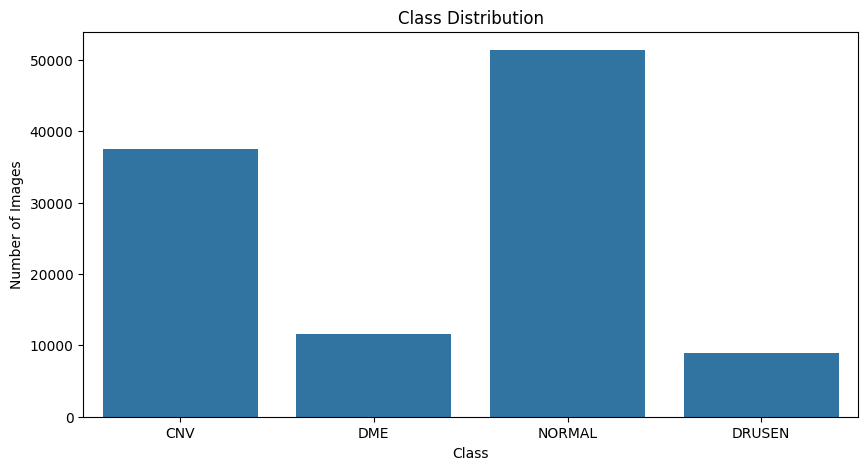

In [10]:
def get_image_paths_and_labels(dataset_path):
    image_paths = []
    labels = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.jpeg'):
                image_paths.append(os.path.join(root, file))
                labels.append(root.split(os.path.sep)[-1])
    return image_paths, labels

image_paths, labels = get_image_paths_and_labels(dataset_path)

num_images = len(image_paths)
num_classes = len(set(labels))

print(f"Number of images: {num_images}")
print(f"Number of classes: {num_classes}")

class_distribution = Counter(labels)
print(f"Class distribution: {class_distribution}")

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## About the Dataset: Examples

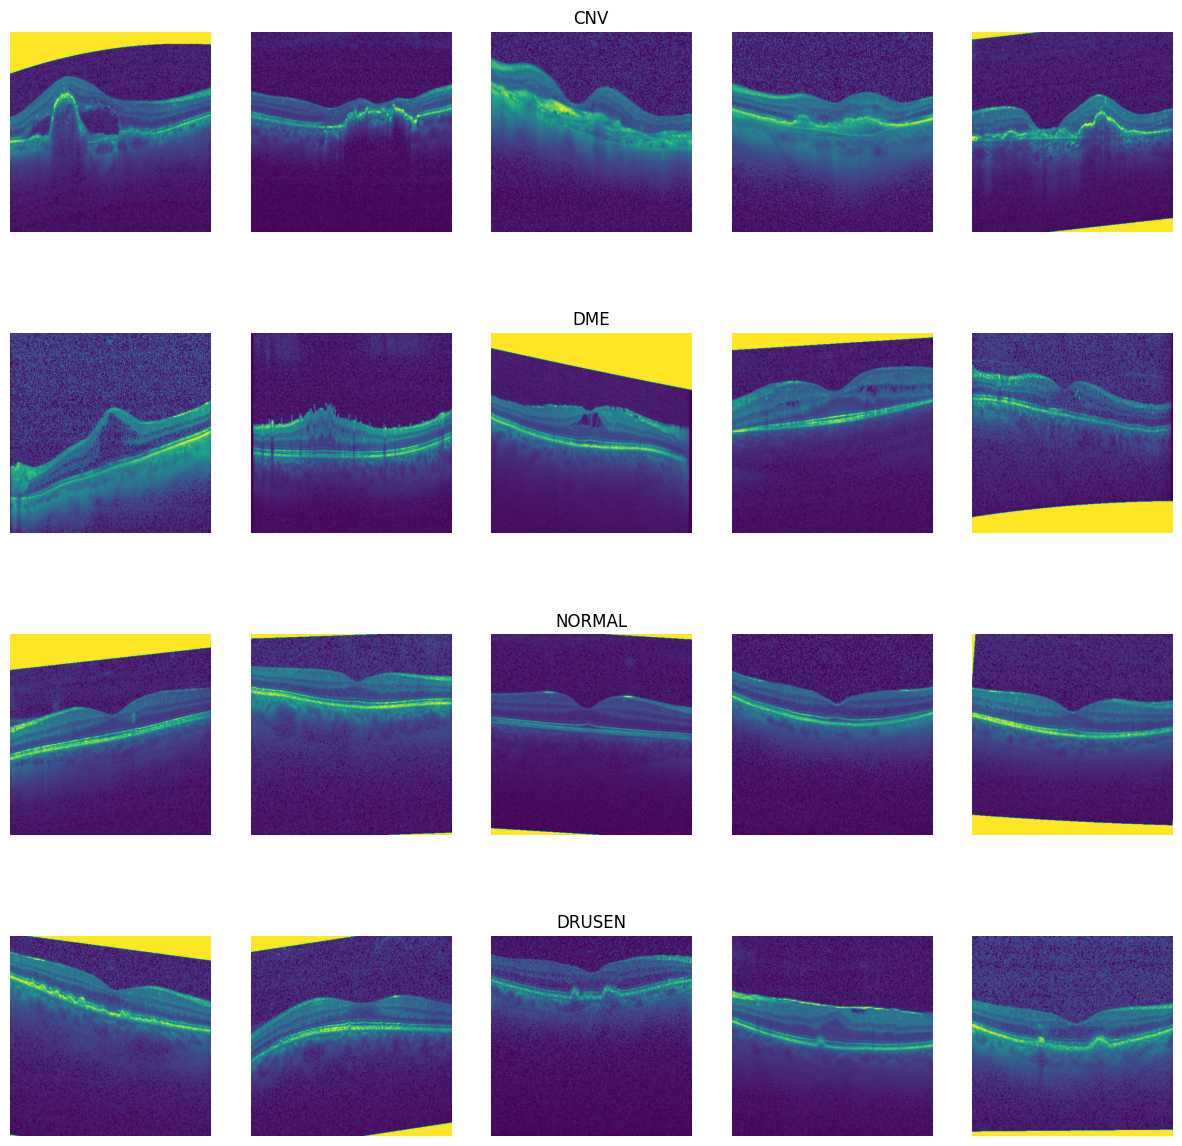

In [17]:
def plot_example_images(image_paths, labels, class_distribution, num_examples=5):
    plt.figure(figsize=(15, 15))
    for i, cls in enumerate(class_distribution.keys()):
        cls_images = [image_paths[j] for j in range(len(image_paths)) if labels[j] == cls]
        for j in range(num_examples):
            img = Image.open(cls_images[j])
            plt.subplot(len(class_distribution), num_examples, i * num_examples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == num_examples // 2:
                plt.title(cls)
    plt.show()

plot_example_images(image_paths, labels, class_distribution)

In [ ]:
image_sizes = [Image.open(img_path).size for img_path in image_paths]

Unique image sizes: {(512, 512), (512, 496), (642, 277), (1024, 496), (900, 455), (384, 496), (1536, 496), (768, 496)}


Image size distribution:
Size: (512, 496), Count: 58037
Size: (768, 496), Count: 29749
Size: (1536, 496), Count: 11512
Size: (1024, 496), Count: 1329
Size: (384, 496), Count: 21
Size: (512, 512), Count: 8659
Size: (642, 277), Count: 1
Size: (900, 455), Count: 1


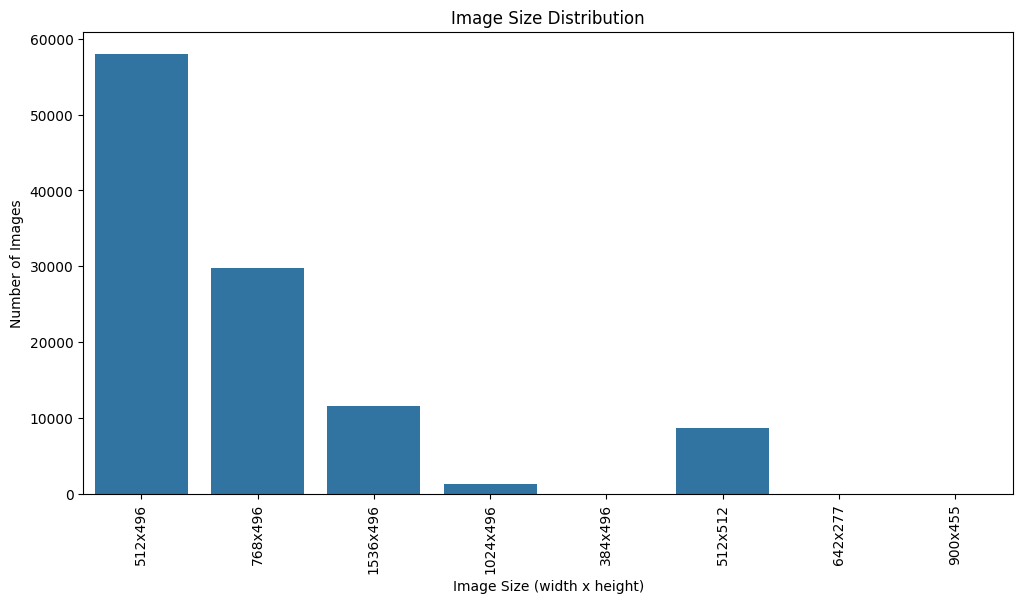

In [ ]:
size_distribution = Counter(image_sizes)

print("Image size distribution:")
for size, count in size_distribution.items():
    print(f"Size: {size}, Count: {count}")

plt.figure(figsize=(12, 6))
sizes, counts = zip(*size_distribution.items())
sizes = [f"{size[0]}x{size[1]}" for size in sizes]  # Format sizes as strings
sns.barplot(x=sizes, y=counts)
plt.title('Image Size Distribution')
plt.xlabel('Image Size (width x height)')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()

# Preprocessing

## Crop

In [15]:
from tqdm import tqdm
import tensorflow as tf

def crop_center(img, cropx, cropy):
    y, x = img.shape[0], img.shape[1]
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]

target_size = (496, 496)

def preprocess_images(image_paths, target_size):
    for img_path in tqdm(image_paths, desc="Processing images"):
        img = Image.open(img_path)
        img = np.array(img)
        img = crop_center(img, *target_size)
        img = Image.fromarray(img)
        img.save(img_path)

preprocess_images(image_paths, target_size)


Processing images: 100%|██████████| 109309/109309 [11:35<00:00, 157.19it/s]


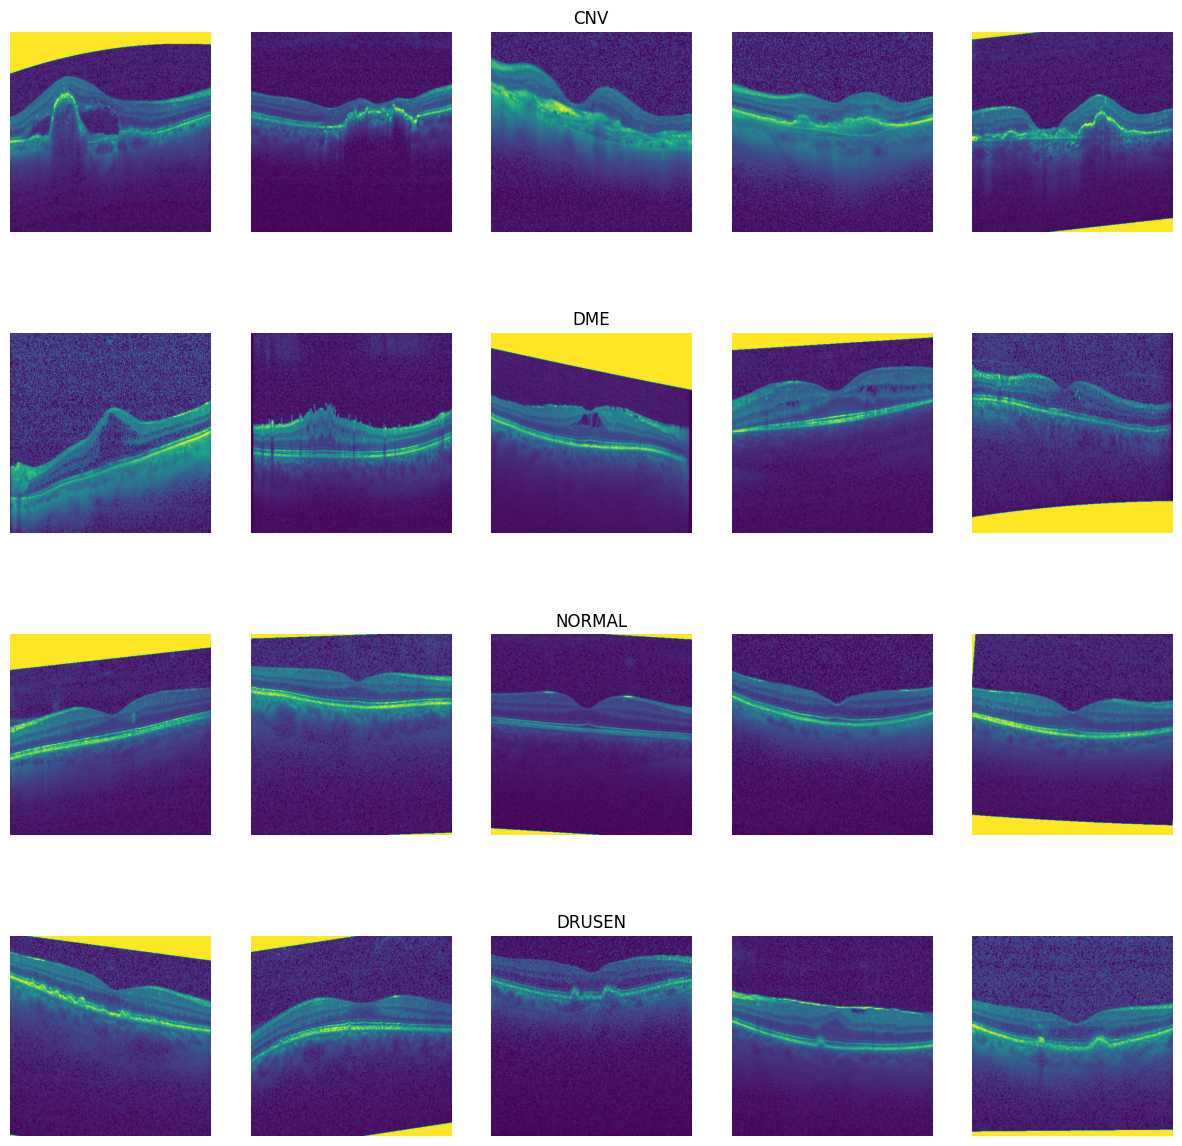

In [18]:
plot_example_images(image_paths, labels, class_distribution)